In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
import os
print(os.getcwd())

c:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\3_Model


In [4]:
from PIL import Image

image_path = r'C:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\1_DatasetCharacteristics\EruptionImages\sorted images\test\activity_no\Barren_Island_22187_2016-04-21.png'

with Image.open(image_path) as img:
    print("Image size:", img.size)  # (width, height)
    print("Image mode:", img.mode)  # e.g., 'RGB', 'RGBA', 'L'


Image size: (512, 468)
Image mode: RGBA


In [ ]:
from PIL import Image
import numpy as np

image_path = r'C:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\1_DatasetCharacteristics\EruptionImages\sorted images\test\activity_no\Barren_Island_22187_2016-04-21.png'

with Image.open(image_path) as img:
    # Convert from RGBA to RGB (drops alpha)
    img_rgb = img.convert('RGB')
    image_array = np.array(img_rgb)

print("New image shape:", image_array.shape)

New image shape: (468, 512, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_dir = r'C:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\1_DatasetCharacteristics\EruptionImages\sorted images\train_val'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# load and split
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 830 files belonging to 2 classes.
Using 664 files for training.
Found 830 files belonging to 2 classes.
Using 166 files for validation.


# plot classes

In [22]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# save class names
class_names = train_ds_raw.class_names
print("Class names:", class_names)


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds_raw.prefetch(AUTOTUNE)

Found 830 files belonging to 2 classes.
Using 664 files for training.
Found 830 files belonging to 2 classes.
Using 166 files for validation.
Class names: ['activity_no', 'activity_yes']


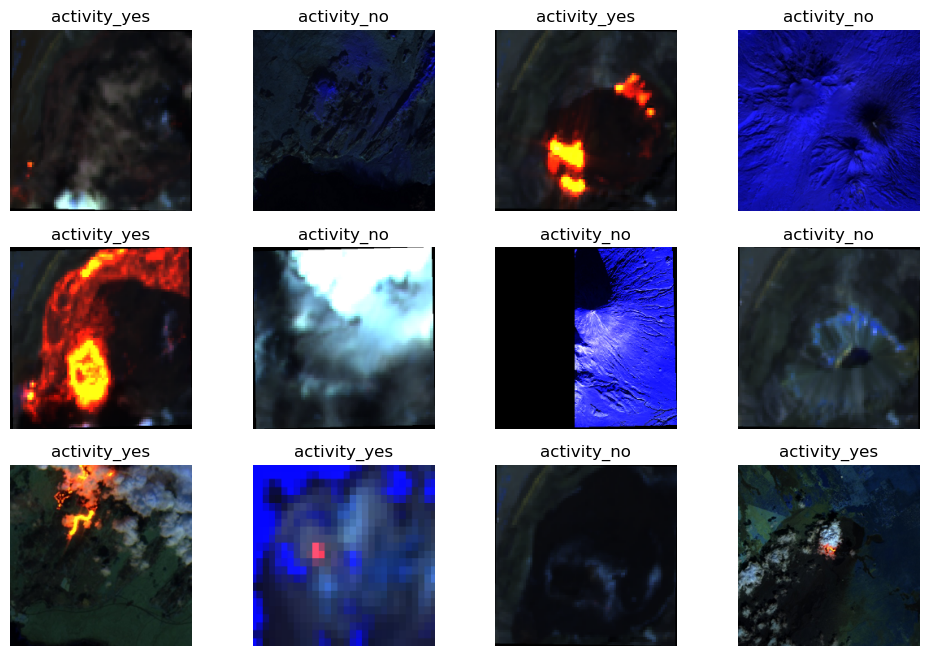

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i])
        plt.title(class_names[label])
        plt.axis("off")

# model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [11]:
# === Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

In [ ]:
# === Load Base Model (MobileNetV2) ===
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze for transf learning

In [ ]:
# --- Build Full Model ---
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(0.001))(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# --- compile for transfer learning ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# --- train (transfer learning) ---
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
21/21 [==============================] - 28s 838ms/step - loss: 0.9382 - accuracy: 0.4714 - auc: 0.4685 - val_loss: 0.7115 - val_accuracy: 0.5482 - val_auc: 0.5688
Epoch 2/10
21/21 [==============================] - 16s 729ms/step - loss: 0.8421 - accuracy: 0.5331 - auc: 0.5405 - val_loss: 0.6727 - val_accuracy: 0.5964 - val_auc: 0.6462
Epoch 3/10
21/21 [==============================] - 17s 818ms/step - loss: 0.8352 - accuracy: 0.5346 - auc: 0.5569 - val_loss: 0.6403 - val_accuracy: 0.6566 - val_auc: 0.7196
Epoch 4/10
21/21 [==============================] - 16s 768ms/step - loss: 0.7385 - accuracy: 0.6084 - auc: 0.6445 - val_loss: 0.6091 - val_accuracy: 0.7289 - val_auc: 0.7810
Epoch 5/10
21/21 [==============================] - 13s 619ms/step - loss: 0.7616 - accuracy: 0.5633 - auc: 0.6136 - val_loss: 0.5834 - val_accuracy: 0.7831 - val_auc: 0.8269
Epoch 6/10
21/21 [==============================] - 13s 609ms/step - loss: 0.6998 - accuracy: 0.6370 - auc: 0.6850 - val_loss

# unfreeze

In [ ]:
# --- unfreeze top Layers for finetuning ---
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# --- recompile ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# --- train again ---
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
21/21 [==============================] - 25s 799ms/step - loss: 0.5972 - accuracy: 0.7169 - auc: 0.8016 - val_loss: 0.4442 - val_accuracy: 0.8675 - val_auc: 0.9377
Epoch 2/10
21/21 [==============================] - 15s 728ms/step - loss: 0.5144 - accuracy: 0.7982 - auc: 0.8723 - val_loss: 0.4089 - val_accuracy: 0.8855 - val_auc: 0.9562
Epoch 3/10
21/21 [==============================] - 15s 702ms/step - loss: 0.4449 - accuracy: 0.8419 - auc: 0.9180 - val_loss: 0.3879 - val_accuracy: 0.8795 - val_auc: 0.9620
Epoch 4/10
21/21 [==============================] - 16s 759ms/step - loss: 0.4363 - accuracy: 0.8449 - auc: 0.9255 - val_loss: 0.3736 - val_accuracy: 0.8976 - val_auc: 0.9662
Epoch 5/10
21/21 [==============================] - 15s 720ms/step - loss: 0.4213 - accuracy: 0.8855 - auc: 0.9341 - val_loss: 0.3641 - val_accuracy: 0.8976 - val_auc: 0.9712
Epoch 6/10
21/21 [==============================] - 16s 748ms/step - loss: 0.4257 - accuracy: 0.8660 - auc: 0.9322 - val_loss

In [17]:
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history:
        combined[key] = h1.history[key] + h2.history[key]
    return combined

combined_history = combine_histories(history1, history2)

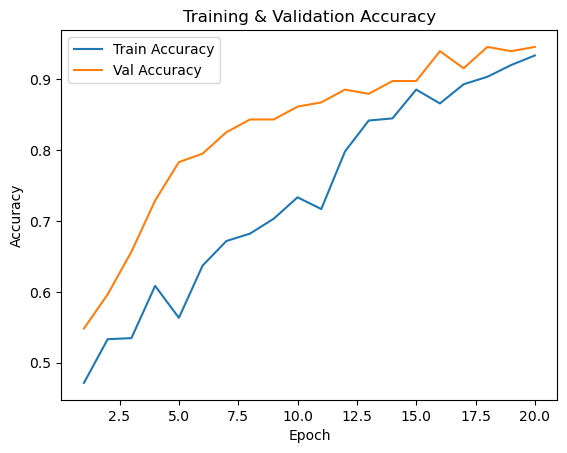

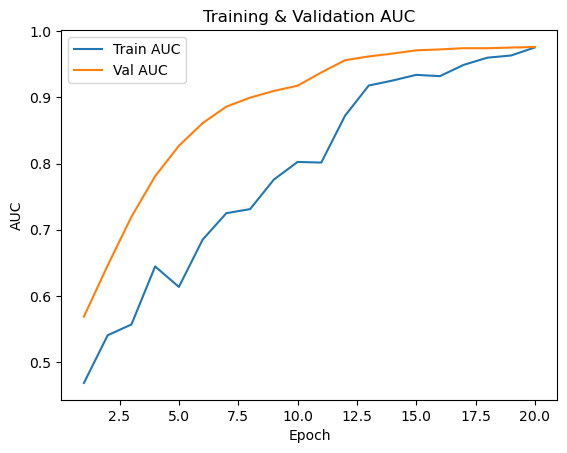

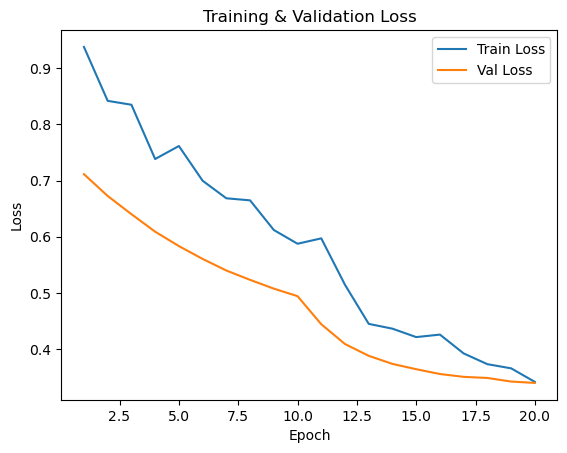

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(combined_history['accuracy']) + 1)

# accuracy
plt.figure()
plt.plot(epochs, combined_history['accuracy'], label='Train Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# AUC
plt.figure()
plt.plot(epochs, combined_history['auc'], label='Train AUC')
plt.plot(epochs, combined_history['val_auc'], label='Val AUC')
plt.title('Training & Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# loss
plt.figure()
plt.plot(epochs, combined_history['loss'], label='Train Loss')
plt.plot(epochs, combined_history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# evaluate test performance

In [19]:
import tensorflow as tf

path_test = r"C:\Users\thsat\sat_imagery_ml\sat-imagery-ml-1\1_DatasetCharacteristics\EruptionImages\sorted images\test"

test_ds = tf.keras.utils.image_dataset_from_directory(
    path_test,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 118 files belonging to 2 classes.


In [20]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test AUC: {results[2]:.4f}")

4/4 [==============================] - 3s 452ms/step - loss: 0.3999 - accuracy: 0.8983 - auc: 0.9568
Test Loss: 0.3999
Test Accuracy: 0.8983
Test AUC: 0.9568


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)

# Confusion matrix & report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Activity", "Activity"]))

4/4 [==============================] - 3s 490ms/step
Confusion Matrix:
 [[54  5]
 [ 7 52]]

Classification Report:
              precision    recall  f1-score   support

 No Activity       0.89      0.92      0.90        59
    Activity       0.91      0.88      0.90        59

    accuracy                           0.90       118
   macro avg       0.90      0.90      0.90       118
weighted avg       0.90      0.90      0.90       118

